# Herschel Stripe 82 master catalogue
## Preparation of UKIRT Infrared Deep Sky Survey / Large Area Survey (UKIDSS/LAS)

Information about UKIDSS can be found at http://www.ukidss.org/surveys/surveys.html

The catalogue comes from `dmu0_UKIDSS-LAS`.

In the catalogue, we keep:

- The identifier (it's unique in the catalogue);
- The position;
- The stellarity;
- The magnitude for each band in aperture 3 (2 arcsec).
- The hall magnitude is described as the total magnitude.

J band magnitudes are available in two eopchs. We take the first arbitrarily.

The magnitudes are “*Vega like*”.  The AB offsets are given by Hewett *et al.* (2016):

| Band | AB offset |
|------|-----------|
| Y    | 0.634     |
| J    | 0.938     |
| H    | 1.379     |
| K    | 1.900     |

Each source is associated with an epoch. These range between 2005 and 2007. We take 2006 for the epoch.

In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))

This notebook was run with herschelhelp_internal version: 
33f5ec7 (Wed Dec 6 16:56:17 2017 +0000)


In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

from collections import OrderedDict
import os

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table
import numpy as np

from herschelhelp_internal.flagging import  gaia_flag_column
from herschelhelp_internal.masterlist import nb_astcor_diag_plot, remove_duplicates
from herschelhelp_internal.utils import astrometric_correction, mag_to_flux

In [3]:
OUT_DIR =  os.environ.get('TMP_DIR', "./data_tmp")
try:
    os.makedirs(OUT_DIR)
except FileExistsError:
    pass

RA_COL = "las_ra"
DEC_COL = "las_dec"

## I - Column selection

In [4]:
#Is the following standard (different names for radec vs mag)?
imported_columns = OrderedDict({
        'SOURCEID': 'las_id',
        'RA': 'las_ra',
        'Dec': 'las_dec',
        'YHALLMAG': 'm_ukidss_y',
        'YHALLMAGERR': 'merr_ukidss_y',
        'YAPERMAG3': 'm_ap_ukidss_y',
        'YAPERMAG3ERR': 'merr_ap_ukidss_y',
        'J_1HALLMAG': 'm_ukidss_j',
        'J_1HALLMAGERR': 'merr_ukidss_j',
        'J_1APERMAG3': 'm_ap_ukidss_j',
        'J_1APERMAG3ERR': 'merr_ap_ukidss_j',
        'HAPERMAG3': 'm_ap_ukidss_h',
        'HAPERMAG3ERR': 'merr_ap_ukidss_h',
        'HHALLMAG': 'm_ukidss_h',
        'HHALLMAGERR': 'merr_ukidss_h',
        'KAPERMAG3': 'm_ap_ukidss_k',
        'KAPERMAG3ERR': 'merr_ap_ukidss_k',
        'KHALLMAG': 'm_ukidss_k',
        'KHALLMAGERR': 'merr_ukidss_k',
        'PSTAR': 'las_stellarity'
    })

catalogue = Table.read(
    "../../dmu0/dmu0_UKIDSS-LAS/data/UKIDSS-LAS_Herschel-Stripe-82.fits")[list(imported_columns)]
for column in imported_columns:
    catalogue[column].name = imported_columns[column]

#Epochs between 2005 and 2007. Rough average:
epoch = 2006

# Clean table metadata
catalogue.meta = None

In [5]:
# Adding flux and band-flag columns
for col in catalogue.colnames:
    if col.startswith('m_'):
        
        errcol = "merr{}".format(col[1:])
        
        # LAS uses a huge negative number for missing values
        catalogue[col][catalogue[col] < -100] = np.nan
        catalogue[errcol][catalogue[errcol] < -100] = np.nan        

        # Vega to AB correction
        if col.endswith('y'):
            catalogue[col] += 0.634
        elif col.endswith('j'):
            catalogue[col] += 0.938
        elif col.endswith('h'):
            catalogue[col] += 1.379
        elif col.endswith('k'):
            catalogue[col] += 1.900
        else:
            print("{} column has wrong band...".format(col))
        
        flux, error = mag_to_flux(np.array(catalogue[col]), np.array(catalogue[errcol]))
        
        # Fluxes are added in µJy
        catalogue.add_column(Column(flux * 1.e6, name="f{}".format(col[1:])))
        catalogue.add_column(Column(error * 1.e6, name="f{}".format(errcol[1:])))
        
        # Band-flag column
        if "ap" not in col:
            catalogue.add_column(Column(np.zeros(len(catalogue), dtype=bool), name="flag{}".format(col[1:])))
        
# TODO: Set to True the flag columns for fluxes that should not be used for SED fitting.

/opt/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:1096: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  ma.MaskedArray.__setitem__(self, index, value)


In [6]:
catalogue[:10].show_in_notebook()

idx,las_id,las_ra,las_dec,m_ukidss_y,merr_ukidss_y,m_ap_ukidss_y,merr_ap_ukidss_y,m_ukidss_j,merr_ukidss_j,m_ap_ukidss_j,merr_ap_ukidss_j,m_ap_ukidss_h,merr_ap_ukidss_h,m_ukidss_h,merr_ukidss_h,m_ap_ukidss_k,merr_ap_ukidss_k,m_ukidss_k,merr_ukidss_k,las_stellarity,f_ukidss_y,ferr_ukidss_y,flag_ukidss_y,f_ap_ukidss_y,ferr_ap_ukidss_y,f_ukidss_j,ferr_ukidss_j,flag_ukidss_j,f_ap_ukidss_j,ferr_ap_ukidss_j,f_ap_ukidss_h,ferr_ap_ukidss_h,f_ukidss_h,ferr_ukidss_h,flag_ukidss_h,f_ap_ukidss_k,ferr_ap_ukidss_k,f_ukidss_k,ferr_ukidss_k,flag_ukidss_k
0,433862346878,10.780595913,-0.000129223693811,20.2362,0.296362,20.3432,0.115142,nan,nan,nan,nan,20.0619,0.147741,20.1174,0.349096,19.8185,0.152875,19.5448,0.283097,0.000171409,29.2101,7.97319,False,26.4681,2.80695,nan,nan,False,nan,nan,34.2946,4.66662,32.5864,10.4775,False,42.9128,6.04226,55.2198,14.3981,False
1,433862346879,10.8333696177,-6.23643295622e-05,20.7321,0.3192,20.5294,0.135316,nan,nan,nan,nan,20.5888,0.239027,21.1071,0.793732,nan,nan,nan,nan,0.00306749,18.4988,5.43854,False,22.2958,2.77874,nan,nan,False,nan,nan,21.1091,4.6472,13.0964,9.57417,False,nan,nan,nan,nan,False
2,433862346881,10.852724721,-0.000610532571668,19.9908,0.18699,20.542,0.136606,nan,nan,nan,nan,20.2763,0.179777,19.5385,0.205607,nan,nan,nan,nan,0.00306749,36.6159,6.30616,False,22.0398,2.77302,nan,nan,False,nan,nan,28.151,4.66127,55.5399,10.5176,False,nan,nan,nan,nan,False
3,433862346882,10.8515730307,-0.000438797882296,19.5506,0.138169,20.1427,0.0959221,19.2315,0.114457,19.7289,0.09569,19.4244,0.082911,18.9036,0.126451,19.0777,0.0785753,18.7677,0.143056,9.52581e-06,54.926,6.9898,False,31.8364,2.81267,73.6885,7.76817,False,46.6072,4.10767,61.6908,4.71095,99.6701,11.6081,False,84.9016,6.14437,112.963,14.8839,False
4,433862346885,10.8131228064,-0.00167437926533,20.6052,0.337929,20.7477,0.164823,nan,nan,nan,nan,19.9673,0.135656,19.6182,0.285299,19.7819,0.148376,19.2456,0.251229,0.000171409,20.793,6.4717,False,18.2351,2.76822,nan,nan,False,nan,nan,37.418,4.67514,51.607,13.5608,False,44.3851,6.06563,72.7391,16.8311,False
5,433862346886,10.7488126007,-0.00228587354144,20.1795,0.214321,20.8601,0.182412,20.8221,0.339144,20.4306,0.181247,20.2561,0.175744,19.8524,0.249454,20.1742,0.210643,20.1374,0.377733,0.000479863,30.7738,6.07463,False,16.4421,2.76239,17.0279,5.31888,False,24.4198,4.07652,28.6781,4.64202,41.596,9.55691,False,30.9252,5.99976,31.9932,11.1306,False
6,433862346887,10.7830579735,-0.00225177569112,20.3407,0.264272,20.7747,0.169201,19.9259,0.198652,20.1462,0.140169,19.8417,0.121016,19.303,0.196935,19.4242,0.106809,18.7035,0.167878,9.52581e-06,26.529,6.45725,False,17.7883,2.77213,38.8726,7.11234,False,31.7344,4.09694,42.0062,4.682,68.9904,12.5137,False,61.7045,6.07014,119.841,18.53,False
7,433862346888,10.7842626274,-0.00211730354719,19.0507,0.0953579,19.881,0.0767292,18.8711,0.0960997,19.3171,0.0662912,18.7057,0.0435461,18.3449,0.0747749,18.332,0.0399497,17.8692,0.0629031,9.52581e-06,87.0372,7.64429,False,40.5128,2.86305,102.702,9.09022,False,68.1042,4.1582,119.6,4.79686,166.746,11.4838,False,168.735,6.20861,258.425,14.9721,False
8,433862346890,10.8480454023,-0.00270797269773,21.6444,0.758328,20.8715,0.183663,20.4897,0.249714,20.4527,0.18471,20.1997,0.167693,20.0458,0.353997,19.7492,0.144575,20.2567,0.673979,9.52581e-06,7.98444,5.5767,False,16.2701,2.75225,23.126,5.31886,False,23.9293,4.07096,30.2083,4.6657,34.8066,11.3485,False,45.7434,6.09112,28.662,17.7921,False
9,433862346893,10.7474988819,-0.00330219454216,15.7817,0.0044827,15.7288,0.00410445,15.6423,0.00408131,15.5806,0.00345701,15.4067,0.00325391,15.4431,0.00432236,15.7567,0.00480228,15.8111,0.00624661,0.49923,1767.37,7.29699,False,1855.54,7.01456,2009.53,7.55385,False,2126.94,6.77222,2496.34,7.48144,2414.19,9.61099,False,1808.55,7.99933,1720.06,9.89608,False


## II - Removal of duplicated sources

We remove duplicated objects from the input catalogues.

In [7]:
SORT_COLS = ['merr_ap_ukidss_j', 'merr_ap_ukidss_k']
FLAG_NAME = 'las_flag_cleaned'

nb_orig_sources = len(catalogue)

catalogue = remove_duplicates(catalogue, RA_COL, DEC_COL, sort_col=SORT_COLS, flag_name=FLAG_NAME)

nb_sources = len(catalogue)

print("The initial catalogue had {} sources.".format(nb_orig_sources))
print("The cleaned catalogue has {} sources ({} removed).".format(nb_sources, nb_orig_sources - nb_sources))
print("The cleaned catalogue has {} sources flagged as having been cleaned".format(np.sum(catalogue[FLAG_NAME])))

/opt/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:1096: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  ma.MaskedArray.__setitem__(self, index, value)


The initial catalogue had 3298592 sources.
The cleaned catalogue has 3296181 sources (2411 removed).
The cleaned catalogue has 2394 sources flagged as having been cleaned


## III - Astrometry correction

We match the astrometry to the Gaia one. We limit the Gaia catalogue to sources with a g band flux between the 30th and the 70th percentile. Some quick tests show that this give the lower dispersion in the results.

In [8]:
gaia = Table.read("../../dmu0/dmu0_GAIA/data/GAIA_Herschel-Stripe-82.fits")
gaia_coords = SkyCoord(gaia['ra'], gaia['dec'])

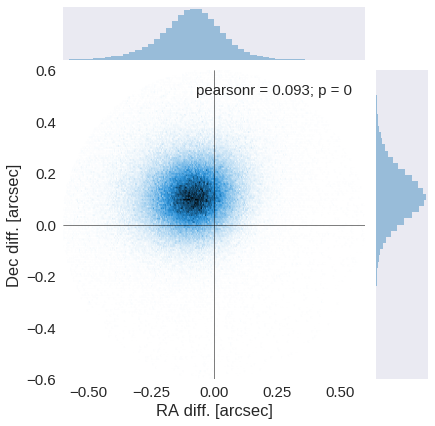

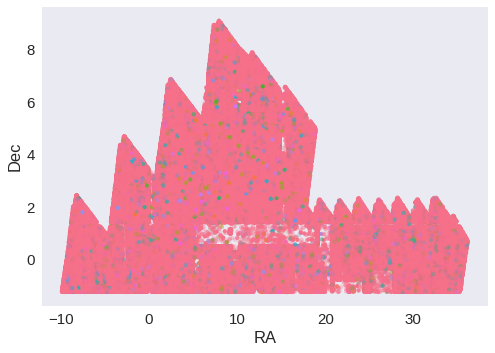

In [9]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec, near_ra0=True)

In [10]:
delta_ra, delta_dec =  astrometric_correction(
    SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]),
    gaia_coords, near_ra0=True
)

print("RA correction: {}".format(delta_ra))
print("Dec correction: {}".format(delta_dec))

RA correction: 0.08633676337694851 arcsec
Dec correction: -0.1104300686126436 arcsec


In [11]:
catalogue[RA_COL] +=  delta_ra.to(u.deg)
catalogue[DEC_COL] += delta_dec.to(u.deg)

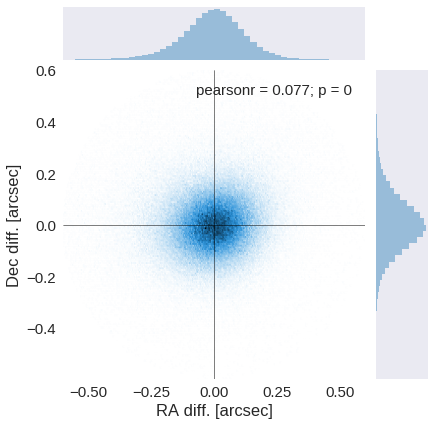

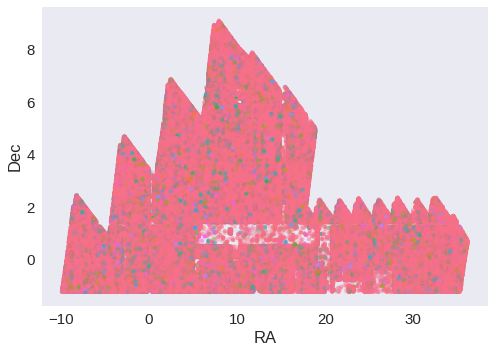

In [12]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec, near_ra0=True)

## IV - Flagging Gaia objects

In [13]:
catalogue.add_column(
    gaia_flag_column(SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]), epoch, gaia)
)

In [14]:
GAIA_FLAG_NAME = "las_flag_gaia"

catalogue['flag_gaia'].name = GAIA_FLAG_NAME
print("{} sources flagged.".format(np.sum(catalogue[GAIA_FLAG_NAME] > 0)))

438850 sources flagged.


## V - Flagging objects near bright stars

# VI - Saving to disk

In [15]:
catalogue.write("{}/UKIDSS-LAS.fits".format(OUT_DIR), overwrite=True)